In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl
from glob import glob

In [2]:
files_ref = sorted(glob('/work/bd1179/b309215/icon-a-ml/build_intel_no_openmp/experiments_project/my_atm_amip_R2B5_ref*/**/*global_means.nc', recursive=True))
files = sorted(glob('/work/bd1179/b309215/icon-a-ml/build_intel_no_openmp/experiments_project/my_atm_amip_R2B5_cpl_alllonlat_start*new/**/*global_means.nc', recursive=True))
files_detailed = sorted(glob('/work/bd1179/b309215/icon-a-ml/build_intel_no_openmp/experiments_project/my_atm_amip_R2B5_cpl_alllonlat_start*new*detailed*/**/*global_means.nc', recursive=True))
files_wpr = sorted(glob('/work/bd1179/b309215/icon-a-ml/build_intel_no_openmp/experiments_project/my_atm_amip_R2B5_cpl_alllonlat_with-qr-qs_start*/**/*global_means.nc', recursive=True))

files_troplat = sorted(glob('/work/bd1179/b309215/icon-a-ml/build_intel_no_openmp/experiments_project/my_atm_amip_R2B5_cpl_alllon_troplat_start*/**/*global_means.nc', recursive=True))
files_troplat_wpr = sorted(glob('/work/bd1179/b309215/icon-a-ml/build_intel_no_openmp/experiments_project/my_atm_amip_R2B5_cpl_alllon_troplat_with-qr-qs_start*/**/*global_means.nc', recursive=True))

len(files_ref), len(files), len(files_detailed), len(files_wpr), len(files_troplat), len(files_troplat_wpr)

(10, 10, 10, 10, 10, 10)

In [5]:
ds_list_ref = [xr.open_dataset(file) for file in files_ref]
ds_list = [xr.open_dataset(file) for file in files]
ds_list_detailed = [xr.open_dataset(file) for file in files_detailed]
ds_list_wpr = [xr.open_dataset(file) for file in files_wpr]
ds_list_troplat = [xr.open_dataset(file) for file in files_troplat]
ds_list_troplat_wpr = [xr.open_dataset(file) for file in files_troplat_wpr]

In [6]:
import pandas as pd

def icon_time_to_date_time(x: float) -> pd.Timestamp:
    a = int(x // 1)
    b = x % 1 * 24*60*60
    return pd.to_datetime(a, format='%Y%m%d') + pd.DateOffset(seconds=b)

for l in [ds_list_ref, ds_list, ds_list_detailed, ds_list_wpr, ds_list_troplat, ds_list_troplat_wpr]:
    for i,ds in enumerate(l):
        ds['time'] = [icon_time_to_date_time(t.item()) for t in ds.time]

In [8]:
def nan_stack(a_list):
    max_len = max(len(l) for l in a_list)
    result = np.stack([np.concatenate((l, np.full(max_len-len(l), np.nan)))
                      for l in a_list])
    return result

In [14]:
for ds_list_last_time in [ds_list, ds_list_wpr]:
    last_times = [(ds.time.values[-1] - ds.time.values[0])/np.timedelta64(1,'D') for ds in ds_list_last_time]
    last_time_min = np.min(last_times)
    last_time_mean = np.mean(last_times)
    last_time_med = np.median(last_times)
    print(f'min: {last_time_min}, mean: {last_time_mean}, median: {last_time_med}')

min: 16.5, mean: 114.6, median: 91.875
min: 0.32083333283564813, mean: 0.5449999995486111, median: 0.5416666660416667


In [15]:
class ShiftedCmap(mpl.colors.Colormap):
    def __init__(self, cmap_string, offset):
        self.cmap = plt.get_cmap(cmap_string)
        self.offset = offset
        self.m = (1-offset)

    def __call__(self, x):
        val = x * self.m + self.offset
        return self.cmap(val)

In [16]:
def plot_ds_list(ds_list, time_limit, average_window, cmap, axis, plot=True, mask_last_step=False, cross_color='red', **kwargs):
    time_days = []
    mmmean_val_list = []
    for i,ds in enumerate(ds_list):
        t_days = (ds.time.values - ds.time.values[0])/np.timedelta64(1,'D')
        plot_vals = ds.tas.values.squeeze()

        limit_mask = (t_days <= time_limit)# & (t_days < 170)
        # limit_mean_mask = (t_days > time_limit-10)# & (t_days < 170)
        # mean_limit_vals = plot_vals[limit_mean_mask]
        t_days = t_days[limit_mask]
        plot_vals = plot_vals[limit_mask]
        # print(plot_vals.shape)
        
        if mask_last_step and t_days[-1] < time_limit:
            if plot:
                axis.scatter(t_days[-1], plot_vals[-2], marker='x', color=cross_color, s=50, zorder=5)
            t_days = t_days[:-1]
            plot_vals = plot_vals[:-1]

        color = cmap(i/len(ds_list)*0.9)
        if average_window > 1:
            plot_vals = np.convolve(plot_vals, np.ones(average_window)/average_window, mode='valid')
            t_days = np.convolve(t_days, np.ones(average_window)/average_window, mode='valid')

        if len(t_days) > len(time_days):
            time_days = t_days
        mmmean_val_list.append(plot_vals)
        if plot:
            axis.plot(t_days, plot_vals, color=color, **kwargs)
    return mmmean_val_list, time_days

In [17]:
def align_yaxis(ax1, v1, ax2, v2):
    """adjust ax2 ylimit so that v2 in ax2 is aligned to v1 in ax1"""
    _, y1 = ax1.transData.transform((0, v1))
    _, y2 = ax2.transData.transform((0, v2))
    inv = ax2.transData.inverted()
    _, dy = inv.transform((0, 0)) - inv.transform((0, y1-y2))
    miny, maxy = ax2.get_ylim()
    ax2.set_ylim(miny+dy, maxy+dy)

In [18]:
import matplotlib.colors as mcolors

def get_complementary_color(hsv_color):
    complementary_hue = (hsv_color[0] + 0.5) % 1.0  # Add 0.5 to the hue and wrap around using modulo 1
    complementary_hsv = (complementary_hue, hsv_color[1], hsv_color[2])
    return mcolors.hsv_to_rgb(complementary_hsv)

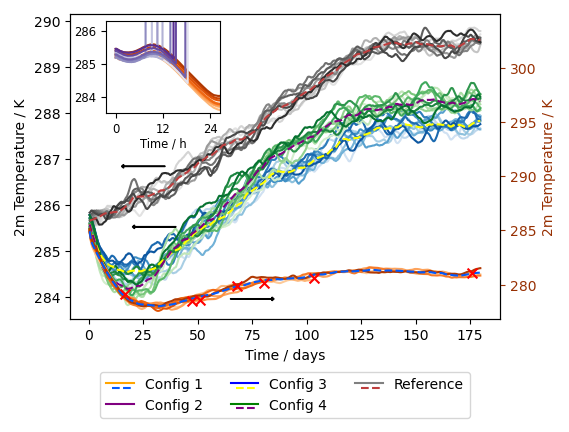

In [104]:
%matplotlib inline

import matplotlib.dates as mdates
from convection_param.setup_mpl_tex import setup_mpl_tex, set_size 
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from matplotlib.ticker import MaxNLocator

draw_inset = True

fig, ax = plt.subplots(constrained_layout=True, figsize=set_size('textwidth'))

# inset axes....
if draw_inset:
    x1, x2, y1, y2 = -0.1, 1.1, 283.5, 286.3  # subregion of the original image
    # xx1, xx2, yy1, yy2 = 92, 185, 284.3, 286.2  # placement of inset axis in original image
    xx1, xx2, yy1, yy2 = 8, 60, 288, 290  # placement of inset axis in original image
    # xx1, xx2, yy1, yy2 = 125, 175, 285, 287  # placement of inset axis in original image
    axins = ax.inset_axes([xx1, yy1, xx2-xx1, yy2-yy1], xlim=(x1, x2), ylim=(y1, y2),
                          xticks=[0,0.5,1],
                          transform=ax.transData,
                          yticks=list(range(int(np.ceil(y1)),int(np.floor(y2))+1)))
                          # ytick)

time_limit = 180 # days
average_window = 4

cmap = ShiftedCmap('Greys', 0.2)
mmmean_val_list_ref, time_days_ref = plot_ds_list(ds_list_ref, time_limit, average_window, cmap, ax, ls='-', alpha=1)

cmap = ShiftedCmap('Blues', 0.2)
mmmean_val_list, time_days = plot_ds_list(ds_list_troplat, time_limit, average_window, cmap, ax, ls='-', alpha=1)

cmap = ShiftedCmap('Greens', 0.2)
mmmean_val_list_wpr, time_days_wpr = plot_ds_list(ds_list_troplat_wpr, time_limit, average_window, cmap, ax, ls='-', alpha=1)

secyax = ax.twinx()
# ylims = ax.get_ylim()

purple_cmap = ShiftedCmap('Oranges', 0.2)
mmmean_val_list_wpr_alllonlat, time_days_wpr_alllonlat = plot_ds_list(ds_list, time_limit, average_window,
                                                                      purple_cmap, secyax, mask_last_step=True,
                                                                      ls='-', alpha=1,
                                                                      cross_color='red')
# ax.set_ylim(ylims)

if draw_inset:
#     cmap = ShiftedCmap('Blues', 0.2)
#     mmmean_val_list, time_days = plot_ds_list(ds_list_troplat, time_limit, average_window, cmap, axins)

#     cmap = ShiftedCmap('Greens', 0.2)
#     mmmean_val_list_wpr, time_days_wpr = plot_ds_list(ds_list_troplat_wpr, time_limit, average_window, cmap, axins)

    cmap = ShiftedCmap('Oranges', 0.2)
    _, _ = plot_ds_list(ds_list_detailed, time_limit, 1, cmap, axins, alpha=1)

    cmap = ShiftedCmap('Purples', 0.2)
    _, _ = plot_ds_list(ds_list_wpr, time_limit, 1, cmap, axins, alpha=1)
# axins.plot([0,175], [285,286])

# mmmean_val_list_wpr_min_len = min(len(l) for l in mmmean_val_list_wpr)
# mmmean_val_list_wpr = [l[:mmmean_val_list_wpr_min_len] for l in mmmean_val_list_wpr]
# time_days_wpr = time_days_wpr[:mmmean_val_list_wpr_min_len]
# # mmmean_val_list_wpr_max_len = max(len(l) for l in mmmean_val_list_wpr)
# # mmmean_val_list_wpr = [np.concatenate((l, np.full(mmmean_val_list_wpr_max_len - len(l), np.nan))) for l in mmmean_val_list_wpr]

mmmean_val_ref = np.nanmean(nan_stack(mmmean_val_list_ref), axis=0)

mmmean_val = np.nanmean(nan_stack(mmmean_val_list), axis=0)
# mmmean_val_roll = np.convolve(mmmean_val, np.ones(average_window)/average_window, mode='valid')
# time_days_roll = np.convolve(time_days, np.ones(average_window)/average_window, mode='valid')

# print([len(l) for l in mmmean_val_list_wpr])
mmmean_val_wpr = np.nanmean(nan_stack(mmmean_val_list_wpr), axis=0)
# print(mmmean_val_wpr.shape, time_days_wpr.shape)
# mmmean_val_wpr_roll = np.convolve(mmmean_val_wpr, np.ones(average_window)/average_window, mode='valid')
# time_days_roll_wpr = np.convolve(time_days_wpr, np.ones(average_window)/average_window, mode='valid')
mmmean_val_wpr_alllonlat = np.nanmean(nan_stack(mmmean_val_list_wpr_alllonlat), axis=0)

# Colors
config_name_color_mapping = {
    'Config 1': 'orange',
    'Config 2': 'purple',
    'Config 3': 'blue',
    'Config 4': 'green',
    'Reference': 'grey',
}
config_name_compcolor_mapping = {}
for name, color in config_name_color_mapping.items():
    hsv_color = mcolors.rgb_to_hsv(mcolors.to_rgb(color))
    config_name_compcolor_mapping[name] = get_complementary_color(hsv_color)
config_name_compcolor_mapping['Reference'] = '#bd3e3e'
# config_name_compcolor_mapping = {
#     'Config 1': 'pink',
#     'Config 2': 'g',
#     'Config 3': 'm',
#     'Config 4': 'y',
#     'Reference': 'c',
# }

ax.plot(time_days, mmmean_val, c=config_name_compcolor_mapping['Config 3'], lw=1.5, ls='--')
ax.plot(time_days_wpr, mmmean_val_wpr, c=config_name_compcolor_mapping['Config 4'], lw=1.5, ls='--')
ax.plot(time_days_ref, mmmean_val_ref, c=config_name_compcolor_mapping['Reference'], lw=1.5, ls='--')
secyax.plot(time_days_wpr_alllonlat, mmmean_val_wpr_alllonlat, c=config_name_compcolor_mapping['Config 1'], lw=1.5, ls='--')

for name, color in config_name_color_mapping.items():
    ax.plot([],[], c=color, ls='-' , label=name)

if draw_inset:
    # axins.plot(time_days_roll, mmmean_val_roll, c='black', ls='-')
    # mark_inset(ax, axins, loc1=2, loc2=3, ec="black", zorder=10)#, linestyle='--')
    axins.set_xticklabels([0,12,24], fontsize='small')
    axins.set_xlabel('Time / h', fontsize='small', labelpad=1)
    axins.set_yticklabels(axins.get_yticklabels(), fontsize='small')

ax.yaxis.set_major_locator(MaxNLocator(integer=True))
# ylims = ax.get_ylim()
# ylims = (273.15, 288.9100879669189)
# ax.set_ylim(ylims)
# ax.set_ylim(284,289.1)
# ax.set_ylim(283.7,288.8)
axylims = ax.get_ylim()
secyax.set_ylim(262,axylims[1])
# Align both axes to common starting date
align_yaxis(ax, mmmean_val[0], secyax, mmmean_val[0])#mmmean_val_wpr_alllonlat[0])
# ax.set_xlim(None,100)
ax.set_xlabel('Time / days')
ax.set_ylabel('2m Temperature / K')
legend = ax.legend(loc='upper center', ncols=3, bbox_to_anchor=(0.5,-0.15))
secyax.set_ylabel('2m Temperature / K', color=purple_cmap(0.9))
secyax.tick_params(axis='y', colors=purple_cmap(0.9))

def get_box(box, subbox):
    x0 = box.x0+subbox.x0*(box.x1-box.x0)
    x1 = box.x0+subbox.x1*(box.x1-box.x0)
    y0 = box.y0+subbox.y0*(box.y1-box.y0)
    y1 = box.y0+subbox.y1*(box.y1-box.y0)
    return x0, y0, x1, y1

fig.draw_without_rendering()
ax_underline = plt.axes([0,0,1,1], facecolor=(1,1,1,0))
# legend_box = fig.transFigure.inverted().transform_bbox(legend.get_window_extent())
# ax_underline.plot([legend_box.x0, legend_box.x1], [legend_box.y0, legend_box.y1], lw=1)#, color=qual_colormap(i))#, transform=fig.transFigure)
for i,title in enumerate(legend.get_texts()):
    if i != 1:
        title_bbox = title.get_window_extent()#renderer=fig.canvas.get_renderer())
        tbox = fig.transFigure.inverted().transform_bbox(title_bbox)
        # ax_underline.plot([tbox.x0, tbox.x1], [tbox.y0, tbox.y0], lw=1.5, color=list(config_name_compcolor_mapping.values())[i], ls='--')#, color=qual_colormap(i))#, transform=fig.transFigure)
        ax_underline.plot([tbox.x0-0.06, tbox.x0-0.02], [tbox.y0+0.01, tbox.y0+0.01], lw=1.5, color=list(config_name_compcolor_mapping.values())[i], ls='--')#, color=qual_colormap(i))#, transform=fig.transFigure)
ax_underline.set_xlim(0,1)
ax_underline.set_ylim(0,1)
ax_underline.axis('off')

arrow_width = 0.01
ax.arrow(40,mmmean_val[40*4]+0.5,-20,0, width=arrow_width, head_width=arrow_width*8, head_length=arrow_width*100, length_includes_head=True, fc='black', zorder=2)
ax.arrow(35,mmmean_val_ref[35*4]+0.5,-20,0, width=arrow_width, head_width=arrow_width*8, head_length=arrow_width*100, length_includes_head=True, fc='black', zorder=2)
secyax_yax_scale = (np.diff(secyax.get_ylim()) / np.diff(ax.get_ylim())).item()
secyax.arrow(65,mmmean_val_wpr_alllonlat[65*4]-1,20,0, width=arrow_width*secyax_yax_scale, head_width=arrow_width*secyax_yax_scale*8, head_length=arrow_width*100, length_includes_head=True, fc='black', zorder=2)

    
# fig.savefig('../../Figures/Pdfplots/SurfaceTemperatureEnsemble10_180days_textwidth.pdf')

plt.show()